### Finding the irreducible **k**-points.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
import numpy as np
import itertools
import copy
from phenum.symmetry import _get_lattice_pointGroup
from itertools import islice
from BZI.sampling import make_grid
from BZI.symmetry import make_rptvecs, make_ptvecs, find_orbitals, find_full_orbitals
from BZI.plots import PlotMesh, PlotMeshes

### Get the points from IBZKPT

In [3]:
file_name = "../dft_data/symmetry/IBZ_Al_msc1_2"
offset = [0., 0., 0.]
ibzpts = []
with open(file_name) as f:
    for i,line in enumerate(islice(f, 0, 1000000000000000)):
        if i < 3:
            continue
        kpt = np.array([float(j) for j in line.split()][:3]) + offset
        ibzpts.append(kpt)

### Create a mesh without an offset

offset  [0.0, 0.0, 0.0]


<IPython.core.display.Javascript object>


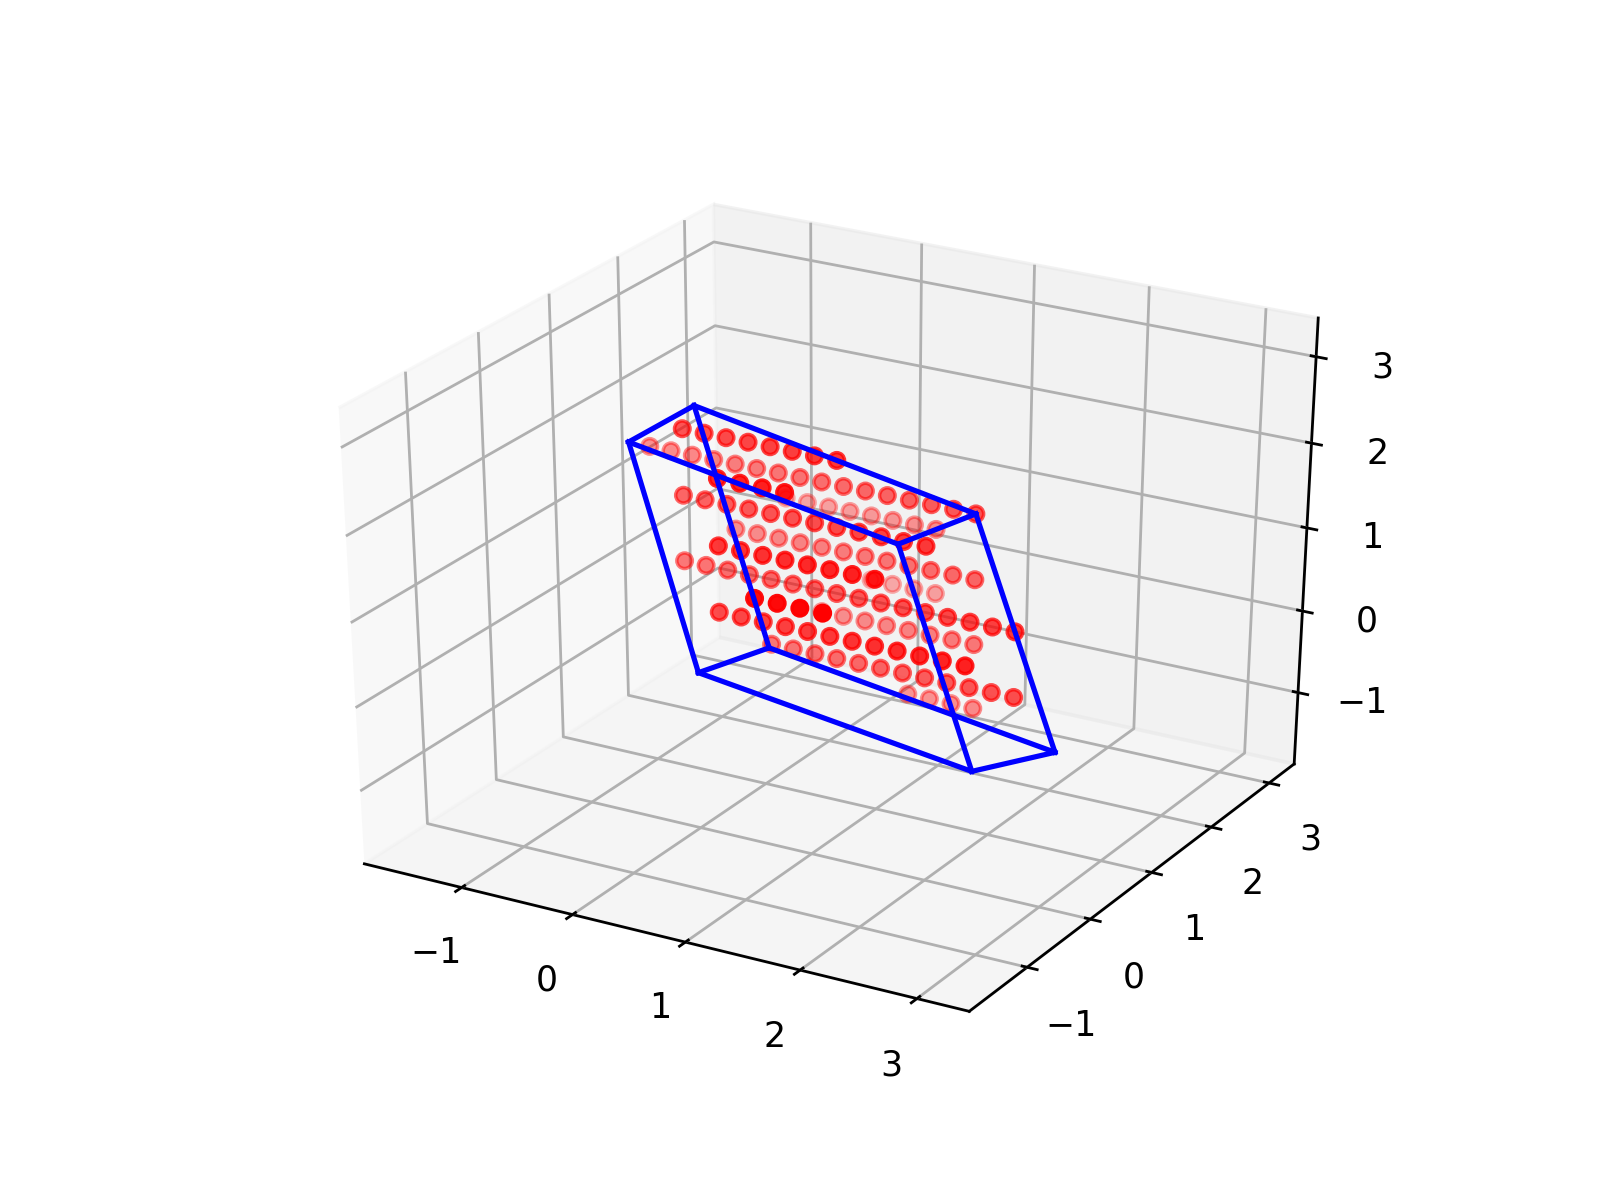

In [5]:
# It's a bit confusing but the cell vectors are made with make_rptvecs with the cell
# type given for the real space lattice. The mesh vectors are made with make_ptvecs.
cell_centering = "face"
cell_const = 4.05
cell_consts = [cell_const]*3
cell_angles = [np.pi/2]*3
cell_vecs = make_ptvecs(cell_centering, cell_consts, cell_angles)
cell_rvecs = make_rptvecs(cell_vecs)

mesh_centering = "prim"
mesh_const = cell_const*2 # the mesh forms a supercell in real space
mesh_consts = [mesh_const*4, mesh_const, mesh_const]
mesh_angles = [np.pi/2]*3
mesh_vecs = make_ptvecs(mesh_centering, mesh_consts, mesh_angles)
mesh_rvecs = make_rptvecs(mesh_vecs)

offset = [0.,0.,0.]
mesh_car = make_grid(cell_rvecs, mesh_rvecs, offset)
mesh_cell = [np.dot(np.linalg.inv(cell_vecs), mp) for mp in mesh_car]

print("offset ", offset)
PlotMesh(mesh_car, cell_rvecs, offset)

In [6]:
point_group = _get_lattice_pointGroup(cell_vecs)
mp_orbitals = find_orbitals(mesh_car, cell_rvecs)

# Check that there are the correct number of points.
print(len([item for sublist in mp_orbitals.values() for item in sublist]) == len(mesh_cell))
print("Total k-points: ", len([item for sublist in mp_orbitals.values() for item in sublist]))
print("Number of irreducible k-points is %s." %len(mp_orbitals))
print("Number of k-points in the IBZKPT file is %s." %len(ibzpts))

True
Total k-points:  128
Number of irreducible k-points is 31.
Number of k-points in the IBZKPT file is 24.


With the origin at the corner of the cell there are 31 irreducible **k**-points.

### Implement Moreno and Solers optimal offset technique

Find candidate offsets.

In [32]:
test = False
while test == False:
    for sym_op in point_group:
        si = sym_op - np.eye(3)
        try:
            the_op = np.linalg.inv(si)
            test = True
        except:
            continue

In [33]:
# Build conditions on origin
origin_cond = []
candidate_origins = []
for n in itertools.product(range(-1,2),repeat=3):
    candidate_origins.append(np.dot(the_op, n*mesh_vecs))
    origin_cond.append(n*mesh_vecs)

mesh_origins = []
for cand_origin in candidate_origins:
    conserve_sym = True
    for sym_op in point_group:
        sym_orig = np.dot(sym_op, cand_origin)
        if not np.where(np.array([np.allclose(sym_orig, oc) for oc in origin_cond]) == True)[0]:
            conserve_sym = False
    if conserve_sym == True:
        mesh_origins.append(cand_origin)
print(mesh_origins)
# Since there is only one offset, there's no need
# to test which one has the greatest symmetry reduction.

[array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])]


The mesh origin shouldn't move.

### Try other offsets. (0, 1/2, 1/2)

offset  [ 0.          0.77570189  0.77570189]


<IPython.core.display.Javascript object>


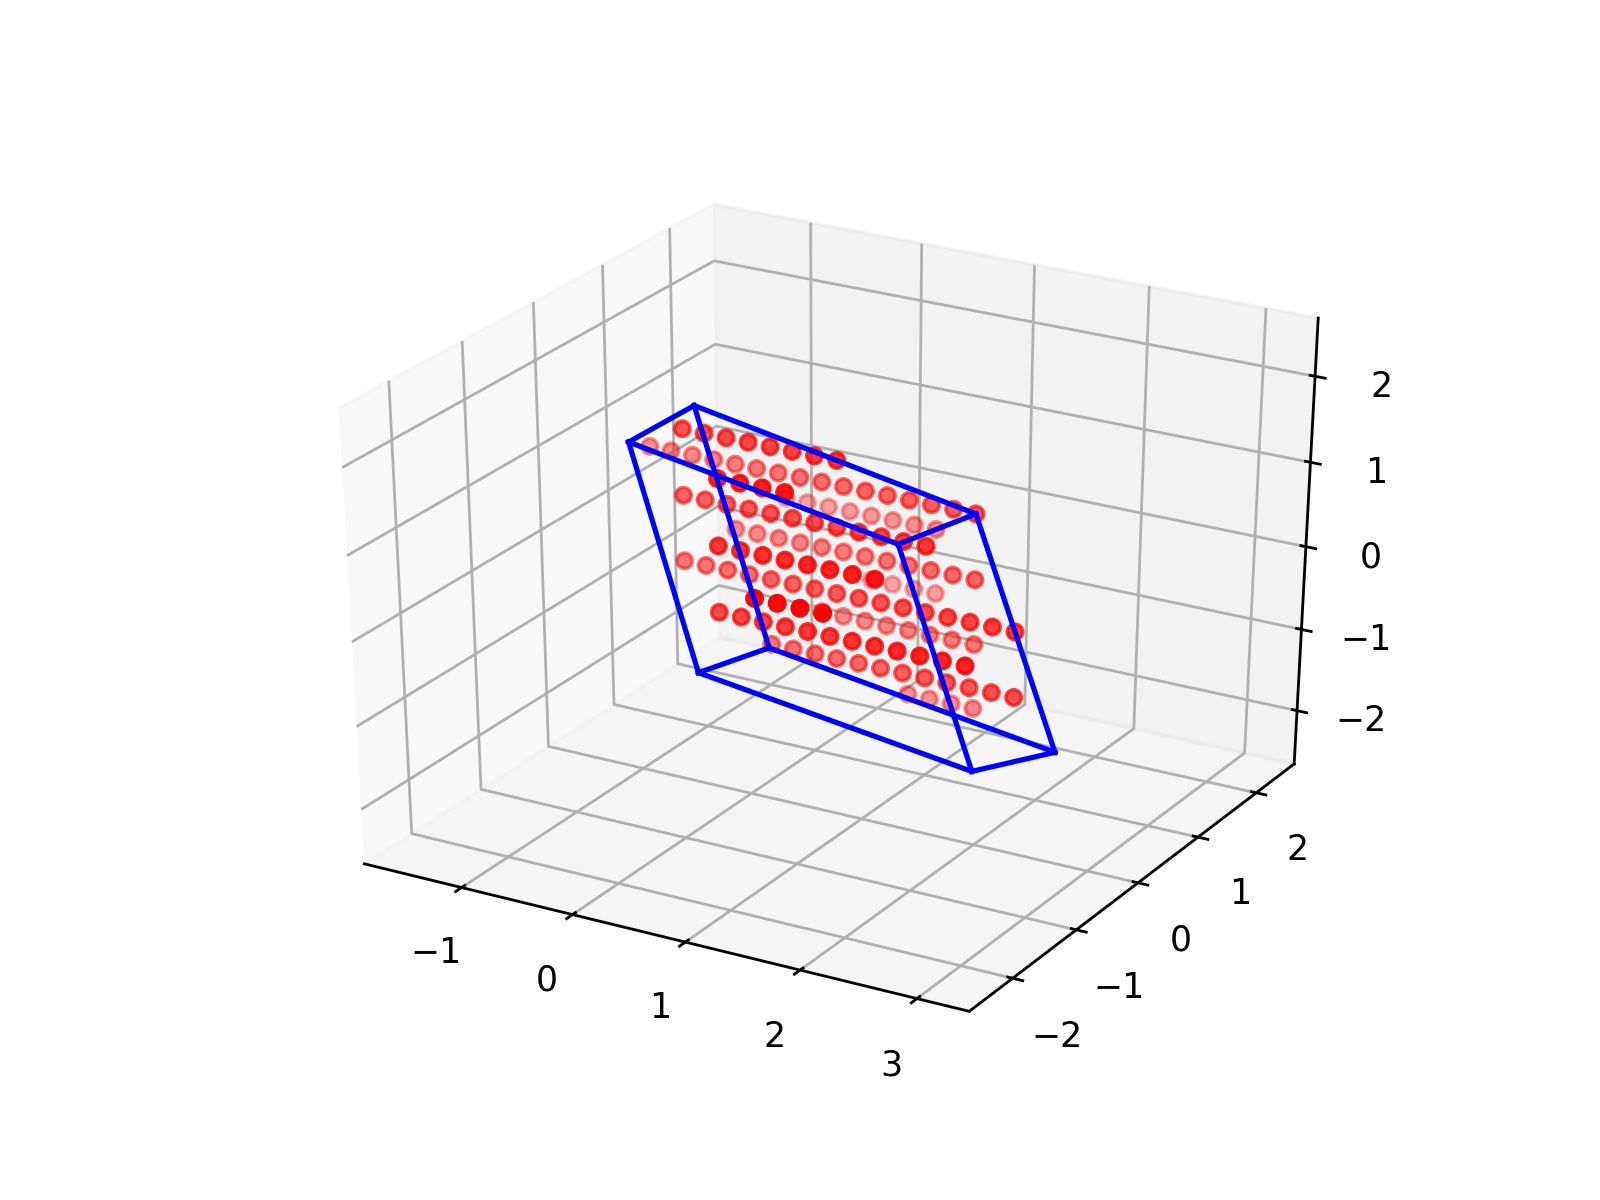

In [7]:
offset = np.sum(cell_rvecs, 1)/2
offset[0] = 0.
print("offset ", offset)
mesh_car = make_grid(cell_rvecs, mesh_rvecs, offset)
mesh_cell = [np.dot(np.linalg.inv(cell_vecs), mp) for mp in mesh_car]

PlotMesh(mesh_car, cell_rvecs, offset)

In [8]:
point_group = _get_lattice_pointGroup(cell_vecs)
mp_orbitals = find_orbitals(mesh_car, cell_rvecs)

len([item for sublist in mp_orbitals.values() for item in sublist]) == len(mesh_cell)
print("Total k-points: ", len([item for sublist in mp_orbitals.values() for item in sublist]))
print("Number of irreducible k-points is %s." %len(mp_orbitals))
print("Number of k-points in the IBZKPT file is %s." %len(ibzpts))

Total k-points:  128
Number of irreducible k-points is 88.
Number of k-points in the IBZKPT file is 24.


### (0,0,1/2)

offset  [ 0.          0.          0.77570189]


<IPython.core.display.Javascript object>


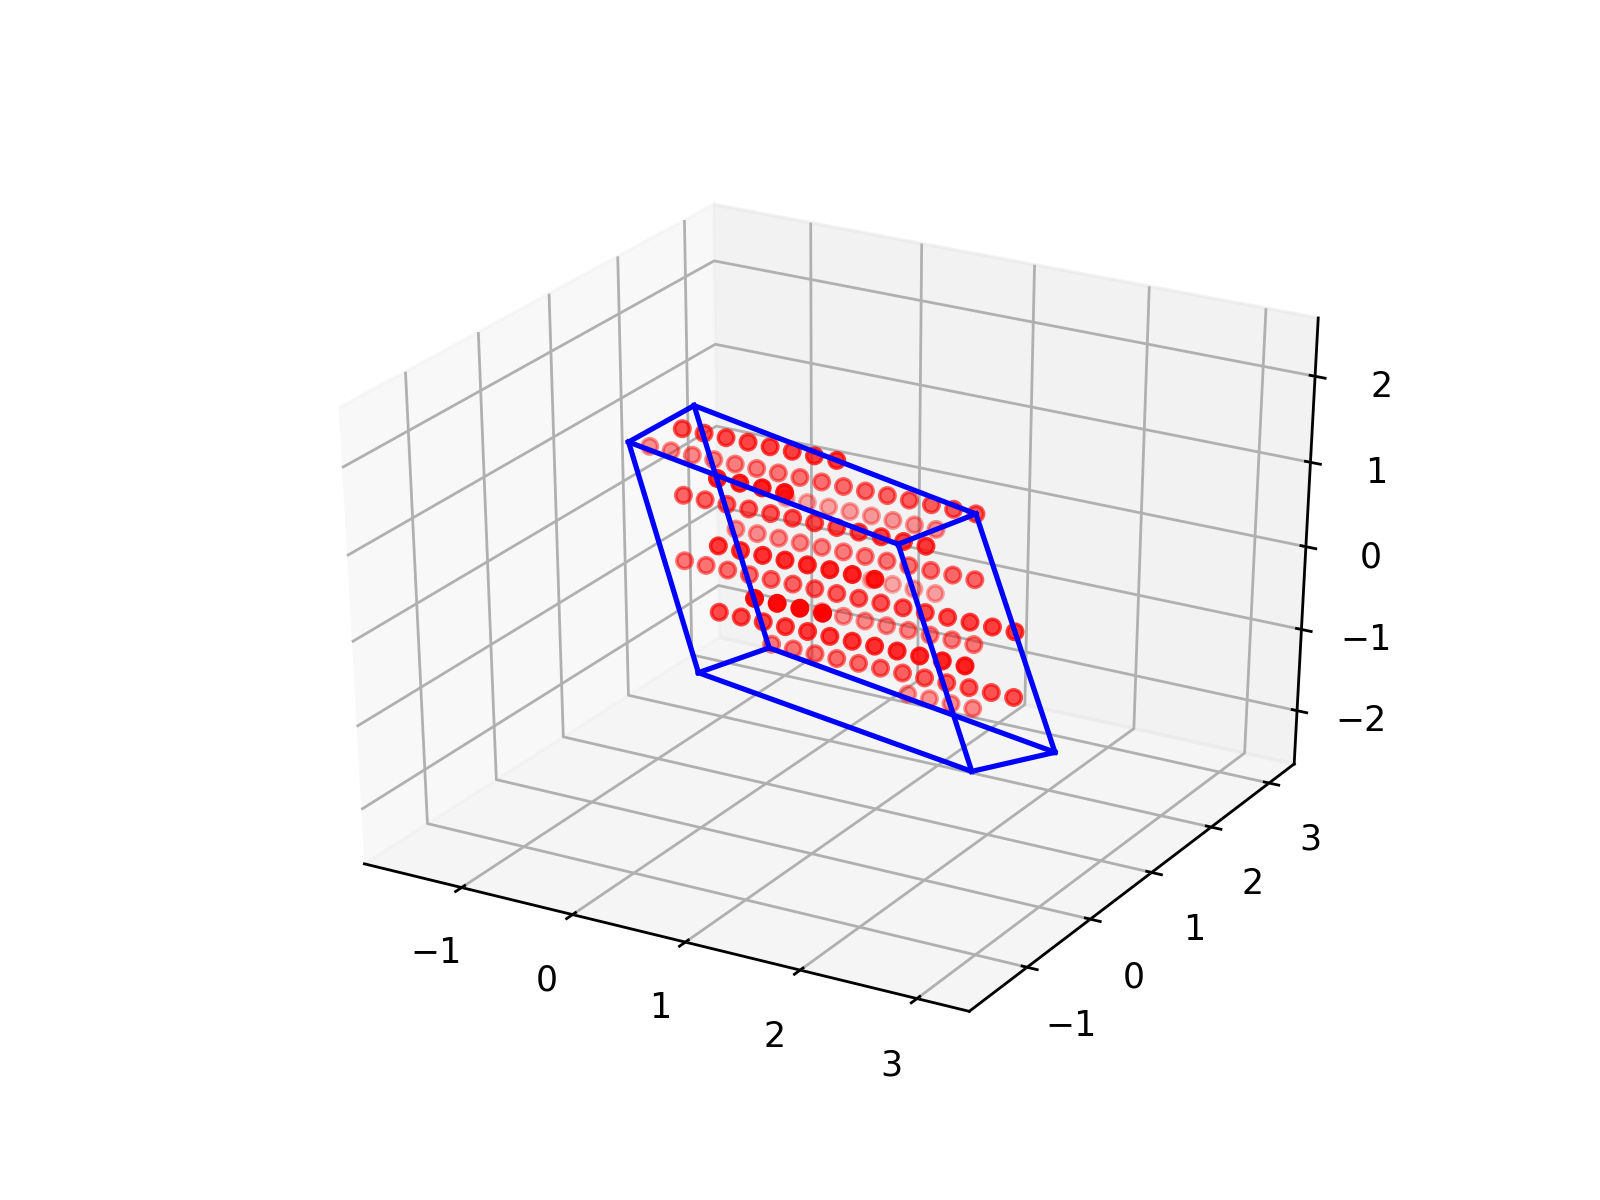

In [9]:
offset = np.sum(cell_rvecs, 1)/2
offset[:2] = 0.
print("offset ", offset)
mesh_car = make_grid(cell_rvecs, mesh_rvecs, offset)
mesh_cell = [np.dot(np.linalg.inv(cell_vecs), mp) for mp in mesh_car]

PlotMesh(mesh_car, cell_rvecs, offset)

In [10]:
point_group = _get_lattice_pointGroup(cell_vecs)
mp_orbitals = find_orbitals(mesh_car, cell_rvecs)

len([item for sublist in mp_orbitals.values() for item in sublist]) == len(mesh_cell)
print("Total k-points: ", len([item for sublist in mp_orbitals.values() for item in sublist]))
print("Number of irreducible k-points is %s." %len(mp_orbitals))
print("Number of k-points in the IBZKPT file is %s." %len(ibzpts))

Total k-points:  128
Number of irreducible k-points is 49.
Number of k-points in the IBZKPT file is 24.


### Move the origin from the corner to the center of the cell.

offset  [ 0.77570189  0.77570189  0.77570189]


<IPython.core.display.Javascript object>


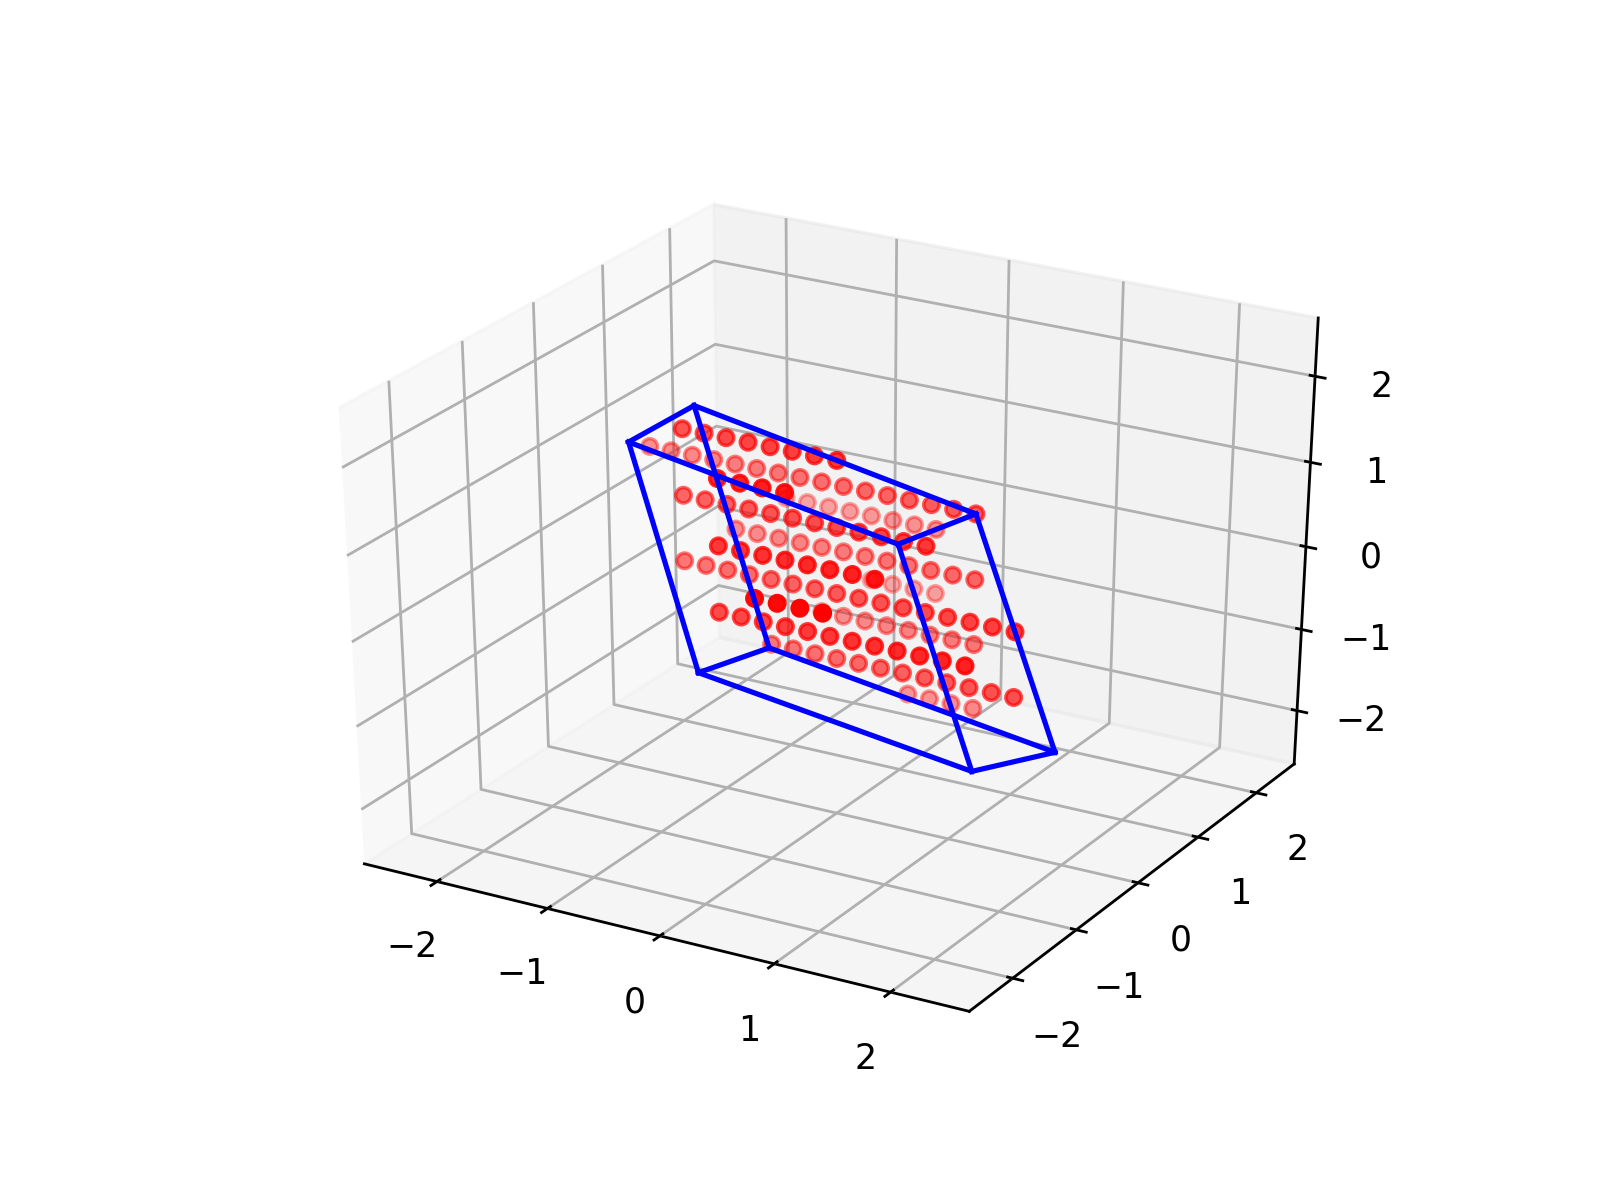

In [11]:
offset = np.sum(cell_rvecs, 1)/2
print("offset ", offset)
mesh_car = make_grid(cell_rvecs, mesh_rvecs, offset)
mesh_cell = [np.dot(np.linalg.inv(cell_vecs), mp) for mp in mesh_car]

PlotMesh(mesh_car, cell_rvecs, offset)

In [12]:
point_group = _get_lattice_pointGroup(cell_vecs)
mp_orbitals = find_orbitals(mesh_car, cell_rvecs)

print(len([item for sublist in mp_orbitals.values() for item in sublist]) == len(mesh_cell))
print("Total k-points: ", len([item for sublist in mp_orbitals.values() for item in sublist]))
print("Number of irreducible k-points is %s." %len(mp_orbitals))
print("Number of k-points in the IBZKPT file is %s." %len(ibzpts))

True
Total k-points:  128
Number of irreducible k-points is 117.
Number of k-points in the IBZKPT file is 24.


### Check that the vasp k-points are a subset of my k-points for the origin at the center of the cell

<IPython.core.display.Javascript object>


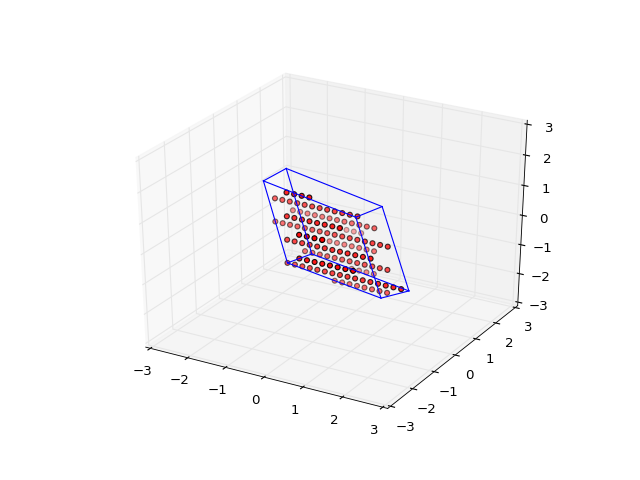

In [51]:
cell_type = "fcc"
cell_const = 4.05
cell_vecs = make_rptvecs(cell_type, cell_const)

scale = [1./4, 1., 1.]
mesh_type = "custom_sc"
mesh_const = 2*np.pi/(cell_const*2)
mesh_vecs = make_ptvecs(mesh_type, mesh_const, scale)
# Swap columns so that it matches the results in VASP.

offset = np.sum(cell_vecs, 1)/2
mesh_car = make_mesh(cell_vecs, mesh_vecs, offset)
mesh_cell = [np.dot(np.linalg.inv(cell_vecs), mp) for mp in mesh_car]

PlotMesh(mesh_car, cell_vecs, offset)

In [52]:
point_group = _get_lattice_pointGroup(cell_vecs)
mp_orbitals = find_orbitals(mesh_car, cell_vecs)

# Check that there are the correct number of points.
print(len([item for sublist in mp_orbitals.values() for item in sublist]) == len(mesh_cell))
print("Total k-points: ", len([item for sublist in mp_orbitals.values() for item in sublist]))
print("Number of irreducible k-points is %s." %len(mp_orbitals))
print("Number of k-points in the IBZKPT file is %s." %len(ibzpts))

True
Total k-points:  128
Number of irreducible k-points is 31.
Number of k-points in the IBZKPT file is 24.


Count the number of points in my mesh that are the same as the irreducible mesh of vasp.

In [54]:
common_pts = 0
for mp in mesh_cell:
    for ibz_pt in ibzpts:
        if np.allclose(mp, ibz_pt):
            common_pts += 1
print("Points in common: ", common_pts)

Points in common:  2


In [17]:
# Make sure the cell vectors are the same as the ones in the KPOINT file.
mesh_vecs*(cell_const/(2*np.pi))

array([[ 0.125,  0.   ,  0.   ],
       [ 0.   ,  0.5  ,  0.   ],
       [ 0.   ,  0.   ,  0.5  ]])

In [18]:
# Make the zeros in the mesh smaller.
for i,mc in enumerate(mesh_cell):
    for j,comp in enumerate(mc):
        if np.isclose(comp%1, 0):
            mesh_cell[i][j] = 0.

In [29]:
# Put the k-points from the IBZKPTS file into cartesian coordinates.
ibzpts_car = []

for pt in ibzpts:
    p = np.dot(cell_vecs,pt)
    for i in range(3):
        if np.isclose(p[i], 0):
            p[i] = 0.
    ibzpts_car.append(p)

In [20]:
common_pts = 0
for mp in mesh_car:
    for ibz_pt in ibzpts_car:
        if np.allclose(mp, ibz_pt):
            common_pts += 1
print("Points in common: ", common_pts)

Points in common:  2


At least it's consistent.

### Play with the mesh vectors to try to decrease excluded points.

In [69]:
swap_columns13 = np.array([[0,0,1],[0,1,0],[1,0,0]])
swap_columns23 = np.array([[1,0,0],[0,0,1],[0,1,0]])
swap_columns12 = np.array([[0,1,0],[1,0,0],[0,0,1]])
shift_columns = np.array([[0,0,1],[1,0,0],[0,1,0]])

cell_type = "fcc"
cell_const = 4.05
cell_vecs = make_rptvecs(cell_type, cell_const)

scale = [1./4, 1., 1.]
mesh_type = "custom_sc"
mesh_const = 2*np.pi/(cell_const*2)
mesh_vecs = make_ptvecs(mesh_type, mesh_const, scale)
# Swap columns so that it matches the results in VASP.
mesh_vecs = np.dot(shift_columns, np.dot(mesh_vecs, swap_columns12))

offset = np.sum(cell_vecs, 1)/2
mesh_car = make_mesh(cell_vecs, mesh_vecs, offset)
mesh_cell = [np.dot(np.linalg.inv(cell_vecs), mp) for mp in mesh_car]
# PlotMeshes([mesh_car, ibzpts_car], cell_vecs, offset)

In [76]:
point_group = _get_lattice_pointGroup(cell_vecs)
mp_orbitals = find_orbitals(mesh_car, cell_vecs, coord="cell")

# Check that there are the correct number of points.
print(len([item for sublist in mp_orbitals.values() for item in sublist]) == len(mesh_cell))
print("Total k-points: ", len([item for sublist in mp_orbitals.values() for item in sublist]))
print("Number of irreducible k-points is %s." %len(mp_orbitals))
print("Number of k-points in the IBZKPT file is %s." %len(ibzpts))

True
Total k-points:  128
Number of irreducible k-points is 31.
Number of k-points in the IBZKPT file is 24.


In [73]:
def exlat_pts(mesh_lat, ibzpts_lat):
    """Find the excluded points in lattice coordinates.
    """
    excluded_pts = []
    ibzcopy = copy.deepcopy(ibzpts_lat)
    common_pts = 0
    for ibz_pt in ibzpts_lat:
        ibz_pt = ibz_pt%.5
        included = False
        for mp in mesh_lat:
            if np.allclose(mp, ibz_pt):
                included = True
                break
        if included == False:
            excluded_pts.append(ibz_pt)
    return excluded_pts

In [74]:
def excar_pts(mesh_car, ibzpts_car):
    """Find the excluded points with them in cartesian coordinates.
    """
    excluded_pts = []
    ibzcopy = copy.deepcopy(ibzpts_car)
    common_pts = 0
    for ibz_pt in ibzpts_car:
        included = False
        for mp in mesh_car:
            if np.allclose(mp, ibz_pt):
                included = True
                break
        if included == False:
            excluded_pts.append(ibz_pt)
    return excluded_pts

In [75]:
# See how the mesh vectors look.
mesh_vecs*(cell_const/(2*np.pi))

array([[ 0.   ,  0.   ,  0.5  ],
       [ 0.   ,  0.125,  0.   ],
       [ 0.5  ,  0.   ,  0.   ]])

In [68]:
excluded_pts = exlat_pts(mesh_cell, ibzpts)
print("Number of excluded points: ", len(excluded_pts))

Number of excluded points:  0


In [313]:
# This might be useful later
swap_columns13 = np.array([[0,0,1],[0,1,0],[1,0,0]])
swap_columns23 = np.array([[1,0,0],[0,0,1],[0,1,0]])
swap_columns12 = np.array([[0,1,0],[1,0,0],[0,0,1]])
shift_columns_left = np.array([[0,0,1],[1,0,0],[0,1,0]])
shift_columns_right = np.array([[0,1,0],[0,0,1],[1,0,0]])
shifts = [np.eye(3), shift_columns_left, shift_columns_right]
rots = [np.eye(3), swap_columns23]
a = np.array([[1,2,3],[1,2,3],[1,2,3]])
As = [a]
for i in range(5):
    As.append(np.dot(np.dot(As[i], shifts[i%2*int(i/3+1)]), rots[(i+1)%2]))
    # print(As[i+1])

In [15]:
len(_get_lattice_pointGroup(cell_vecs))

48

In [16]:
len(_get_lattice_pointGroup(mesh_vecs))

16

The mesh does indeed have lower symmetry than the reciprocal lattice.

Let's see if the orbitals are distinct.

In [18]:
full_orbitals = find_full_orbitals(mesh_car, cell_vecs, coord="cell")

In [22]:
duplicates = []
for pt1 in [item for sublist in full_orbitals.values() for item in sublist][:4]:
    d = -1
    for pt2 in [item for sublist in full_orbitals.values() for item in sublist]:
        if np.allclose(pt1, pt2):
            d += 1
    duplicates.append(d)

In [23]:
duplicates

[5, 5, 5, 5]

Apparently the orbitals are not unique and the same point may be contained in the orbital of several operators.

In [27]:
for i in ibzpts:
    print(np.dot())

[ 0.  0.  0.]
[ 0.      0.0625  0.0625]
[ 0.     0.125  0.125]
[ 0.      0.1875  0.1875]
[ 0.    0.25  0.25]
[ 0.      0.3125  0.3125]
[ 0.     0.375  0.375]
[ 0.      0.4375  0.4375]
[ 0.   0.5  0.5]
[ 0.25    0.0625  0.3125]
[ 0.25   0.125  0.375]
[ 0.25    0.1875  0.4375]
[ 0.25  0.25  0.5 ]
[ 0.25    0.3125 -0.4375]
[ 0.25   0.375 -0.375]
[ 0.25    0.4375 -0.3125]
[ 0.25  0.5  -0.25]
[ 0.5     0.0625 -0.4375]
[ 0.5    0.125 -0.375]
[ 0.5     0.1875 -0.3125]
[ 0.5     0.3125  0.3125]
[ 0.5    0.375  0.375]
[ 0.5     0.4375  0.4375]
[ 0.5  0.5  0.5]


<IPython.core.display.Javascript object>


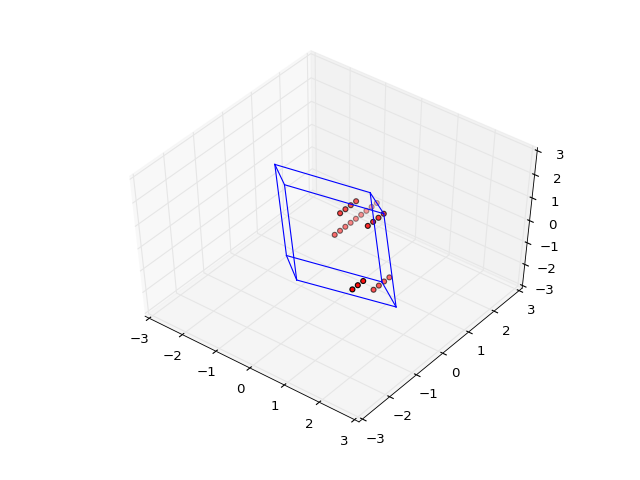

In [31]:
PlotMesh(ibzpts_car, cell_vecs, offset)

In [38]:
for i in ibzpts:
    print(i)

[ 0.  0.  0.]
[ 0.      0.0625  0.0625]
[ 0.     0.125  0.125]
[ 0.      0.1875  0.1875]
[ 0.    0.25  0.25]
[ 0.      0.3125  0.3125]
[ 0.     0.375  0.375]
[ 0.      0.4375  0.4375]
[ 0.   0.5  0.5]
[ 0.25    0.0625  0.3125]
[ 0.25   0.125  0.375]
[ 0.25    0.1875  0.4375]
[ 0.25  0.25  0.5 ]
[ 0.25    0.3125 -0.4375]
[ 0.25   0.375 -0.375]
[ 0.25    0.4375 -0.3125]
[ 0.25  0.5  -0.25]
[ 0.5     0.0625 -0.4375]
[ 0.5    0.125 -0.375]
[ 0.5     0.1875 -0.3125]
[ 0.5     0.3125  0.3125]
[ 0.5    0.375  0.375]
[ 0.5     0.4375  0.4375]
[ 0.5  0.5  0.5]


In [ ]:
A = np.array([[0., .5, .5],[.5, 0., .5],[.5, .5, 0.]])
B = np.array([[0., .5, .5],[.5, 0., .5],[.5, .5, 0.]])

In [33]:
# It's a bit confusing but the cell vectors are made with make_rptvecs with the cell
# type given for the real space lattice. The mesh vectors are made with make_ptvecs.
cell_type = "fcc"
cell_const = 4.05
cell_vecs = make_rptvecs(cell_type, cell_const)

scale = [1./4, 1., 1.]
mesh_type = "custom_bcc"
mesh_const = 2*np.pi/(cell_const*2)
mesh_vecs = make_ptvecs(mesh_type, mesh_const, scale)

offset = [0.,0.,0.]
mesh_car = make_mesh(cell_vecs, mesh_vecs, offset)
mesh_cell = [np.dot(np.linalg.inv(cell_vecs), mp) for mp in mesh_car]

In [34]:
cell_vecs

array([[ 1.55140378,  1.55140378, -1.55140378],
       [-1.55140378,  1.55140378,  1.55140378],
       [ 1.55140378, -1.55140378,  1.55140378]])

In [35]:
mesh_vecs

array([[ 0.09696274, -0.38785094,  0.38785094],
       [ 0.09696274,  0.38785094, -0.38785094],
       [-0.09696274,  0.38785094,  0.38785094]])

In [37]:
np.dot(cell_vecs, np.linalg.inv(mesh_vecs))

array([[ 6., 10.,  0.],
       [-6., -6.,  4.],
       [10.,  6.,  0.]])

In [6]:
cell_const = 1
cell_type = "sc"
cell_vecs = make_ptvecs(cell_type, cell_const)
point_group = _get_lattice_pointGroup(cell_vecs)

mesh_car = [[0., -0.565685, -0.4], [0., -0.565685, 0.], [0., -0.565685,0.4], [-0.282843, -0.282843, -0.4], [-0.282843, -0.282843, 
  0.], [-0.282843, -0.282843, 0.4], [-0.565685, 0., -0.4], [-0.565685,
   0., 0.], [-0.565685, 0., 
  0.4], [0.282843, -0.282843, -0.4], [0.282843, -0.282843, 
  0.], [0.282843, -0.282843, 0.4], [0., 0., -0.4], [0., 0., 0.], [0., 
  0., 0.4], [-0.282843, 0.282843, -0.4], [-0.282843, 0.282843, 
  0.], [-0.282843, 0.282843, 0.4], [0.565685, 0., -0.4], [0.565685, 
  0., 0.], [0.565685, 0., 0.4], [0.282843, 0.282843, -0.4], [0.282843,
   0.282843, 0.], [0.282843, 0.282843, 0.4], [0., 
  0.565685, -0.4], [0., 0.565685, 0.], [0., 0.565685, 0.4]]
mp_orbitals = find_orbitals(mesh_car, cell_vecs)

In [7]:
mp_orbitals

{1: [array([ 0.      ,  0.565685,  0.4     ]),
  array([ 0.      , -0.565685, -0.4     ]),
  array([ 0.      , -0.565685,  0.4     ]),
  array([ 0.      ,  0.565685, -0.4     ]),
  array([-0.565685,  0.      , -0.4     ]),
  array([-0.565685,  0.      ,  0.4     ]),
  array([ 0.565685,  0.      , -0.4     ]),
  array([ 0.565685,  0.      ,  0.4     ])],
 2: [array([ 0.      ,  0.565685,  0.      ]),
  array([ 0.      , -0.565685,  0.      ]),
  array([-0.565685,  0.      ,  0.      ]),
  array([ 0.565685,  0.      ,  0.      ])],
 3: [array([ 0.282843,  0.282843,  0.4     ]),
  array([-0.282843, -0.282843, -0.4     ]),
  array([-0.282843, -0.282843,  0.4     ]),
  array([-0.282843,  0.282843, -0.4     ]),
  array([-0.282843,  0.282843,  0.4     ]),
  array([ 0.282843, -0.282843, -0.4     ]),
  array([ 0.282843, -0.282843,  0.4     ]),
  array([ 0.282843,  0.282843, -0.4     ])],
 4: [array([ 0.282843,  0.282843,  0.      ]),
  array([-0.282843, -0.282843,  0.      ]),
  array([-0.28284

In [ ]:
[[0., 0.565685, 0.4], [0., 0.565685, 0.], [0.282843, 0.282843, 0.4], [0.282843, 0.282843, 0.], [0., 0., 0.4], [0., 0., 0.]]

In [8]:
mesh_car= [[-0.8, -0.8, 0.], [-0.8, 0., 0.8], [0., -0.8, 
   0.8], [-0.8, 0., -0.8], [-0.8, 0.8, 
   0.], [0., -0.8, -0.8], [0., 0., 0.], [0., 0.8, 
   0.8], [0.8, -0.8, 0.], [0.8, 0., 0.8], [0., 
   0.8, -0.8], [0.8, 0., -0.8], [0.8, 0.8, 0.]]

In [9]:
cell_const = 1
cell_type = "fcc"
cell_vecs = make_ptvecs(cell_type, cell_const)
point_group = _get_lattice_pointGroup(cell_vecs)
mp_orbitals = find_orbitals(mesh_car, cell_vecs)

In [10]:
mp_orbitals

{1: [array([ 0.8,  0.8,  0. ]),
  array([-0.8, -0.8,  0. ]),
  array([-0.8,  0. , -0.8]),
  array([ 0. , -0.8, -0.8]),
  array([ 0. ,  0.8,  0.8]),
  array([ 0.8,  0. ,  0.8])],
 2: [array([ 0.8,  0. , -0.8]),
  array([-0.8,  0. ,  0.8]),
  array([-0.8,  0.8,  0. ]),
  array([ 0. , -0.8,  0.8]),
  array([ 0. ,  0.8, -0.8]),
  array([ 0.8, -0.8,  0. ])],
 3: [array([ 0.,  0.,  0.])]}

In [ ]:
[[0.8, 0.8, 0.], [0.,0.,0.], [0.8, 0., -0.8]]

In [13]:
mesh_car = [[-0.4, -0.4, -0.4], [-0.8, 0., 0.], [0., -0.8, 
    0.], [-0.4, -0.4, 0.4], [0., 0., -0.8], [-0.4, 
    0.4, -0.4], [0.4, -0.4, -0.4], [0., 0., 0.], [-0.4, 0.4,
     0.4], [0.4, -0.4, 0.4], [0., 0., 0.8], [0.4, 
    0.4, -0.4], [0., 0.8, 0.], [0.8, 0., 0.], [0.4, 0.4, 
    0.4]];

In [14]:
cell_const = 1
cell_type = "bcc"
cell_vecs = make_ptvecs(cell_type, cell_const)
point_group = _get_lattice_pointGroup(cell_vecs)
mp_orbitals = find_orbitals(mesh_car, cell_vecs)

In [16]:
mp_orbitals

{1: [array([ 0.4,  0.4,  0.4]), array([-0.4, -0.4, -0.4])],
 2: [array([ 0.8,  0. ,  0. ]),
  array([-0.8,  0. ,  0. ]),
  array([ 0. , -0.8,  0. ]),
  array([ 0. ,  0. , -0.8]),
  array([ 0. ,  0. ,  0.8]),
  array([ 0. ,  0.8,  0. ])],
 3: [array([ 0.4,  0.4, -0.4]),
  array([-0.4, -0.4,  0.4]),
  array([-0.4,  0.4, -0.4]),
  array([-0.4,  0.4,  0.4]),
  array([ 0.4, -0.4, -0.4]),
  array([ 0.4, -0.4,  0.4])],
 4: [array([ 0.,  0.,  0.])]}

In [ ]:
{{0.,0.,0.}, {0.4, 0.4, -0.4}, {-0.8, 0., 0.},{0.4, 0.4, 0.4}}